# Housing in buenos

In [41]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [42]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

warnings.simplefilter(action="ignore", category=FutureWarning)

## Wragnle function

In [43]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # neighbourhood
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand = True)[3]
    df.drop(columns = "place_with_parent_names", inplace = True)

    return df

In [44]:
files = glob("downloads/buenos-aires-real-estate-*.csv")
files

['downloads\\buenos-aires-real-estate-1.csv',
 'downloads\\buenos-aires-real-estate-2.csv',
 'downloads\\buenos-aires-real-estate-4.csv',
 'downloads\\buenos-aires-real-estate-5.csv']

In [45]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)

In [46]:
len(frames)

4

In [47]:
type(frames[0])

pandas.core.frame.DataFrame

In [48]:
df = pd.concat(frames, ignore_index = True)
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
1,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
2,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
3,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
4,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


In [49]:
#Split the model
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

In [50]:
#baseline
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)

print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132012.9520570457
Baseline MAE: 44551.47576764096


In [51]:
# Transformations (Transformer)
#Instantiate
ohe = OneHotEncoder(use_cat_names=True)
#fit
ohe.fit(X_train)
#transform
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(5294, 57)


,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Flores,neighborhood_Belgrano,neighborhood_Liniers,...,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati,neighborhood_Villa Real,neighborhood_Pompeya,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
#putting onehotencoder and LinearRegression in a pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train, y_train)

,steps,"[('onehotencoder', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,['neighborhood']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


In [53]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 38992.99


In [54]:
X_test = pd.read_csv("downloads/buenos-aires-test-features.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    244044.856950
1    163035.311536
2     97389.020956
3    110750.848103
4    126118.356379
dtype: float64

In [40]:
#pipeline multiple equations solution approach
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 54
[38380.13520469  -320.17402333 24189.75369155  4622.374326
 47962.13266672]


In [35]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 54
['neighborhood_Belgrano' 'neighborhood_Caballito'
 'neighborhood_Colegiales' 'neighborhood_Almagro' 'neighborhood_Palermo']


In [36]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Belgrano      39647.357253
neighborhood_Caballito       603.882415
neighborhood_Colegiales    26013.245329
neighborhood_Almagro        5624.503584
neighborhood_Palermo       49229.864470
dtype: float64

In [37]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 120030.27
+ (39647.36 * neighborhood_Belgrano)
+ (603.88 * neighborhood_Caballito)
+ (26013.25 * neighborhood_Colegiales)
+ (5624.5 * neighborhood_Almagro)
+ (49229.86 * neighborhood_Palermo)
+ (8095.22 * neighborhood_Saavedra)
+ (-5118.51 * neighborhood_Once)
+ (-1257.36 * neighborhood_Congreso)
+ (-13307.59 * neighborhood_Balvanera)
+ (1180.31 * neighborhood_Villa Crespo)
+ (-16847.76 * neighborhood_Flores)
+ (1424.1 * neighborhood_San Telmo)
+ (-21705.27 * neighborhood_)
+ (-23230.27 * neighborhood_Villa Pueyrredón)
+ (1425.61 * neighborhood_Barracas)
+ (52438.02 * neighborhood_Barrio Norte)
+ (22241.16 * neighborhood_Retiro)
+ (-548.34 * neighborhood_Boedo)
+ (6123.1 * neighborhood_Villa Urquiza)
+ (-21530.27 * neighborhood_Villa Ortuzar)
+ (-57238.85 * neighborhood_Pompeya)
+ (-57048.83 * neighborhood_Constitución)
+ (23430.44 * neighborhood_Coghlan)
+ (-16163.4 * neighborhood_Villa del Parque)
+ (-12230.27 * neighborhood_Parque Chacabuco)
+ (71725.89 * neighborhood_Recole

Text(0.5, 1.0, 'Feature Importance for Apartment Price')

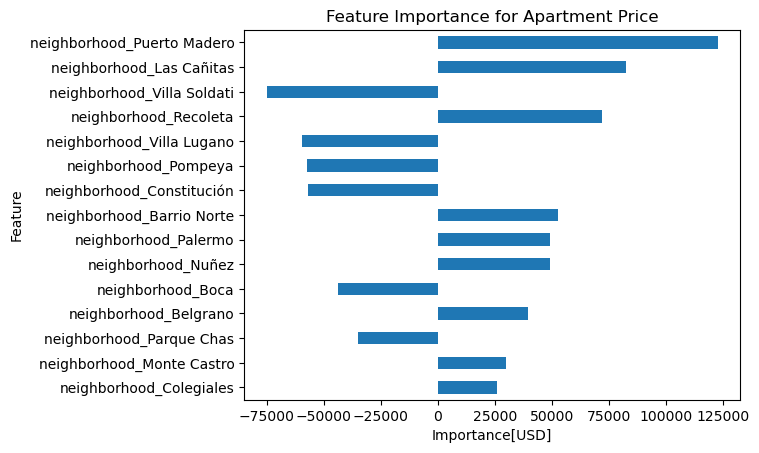

In [55]:
feat_imp.sort_values(key=abs).tail(15).plot(kind = "barh")
plt.xlabel("Importance[USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price")